# Hedge Fund Portfolio Solutions - Research

## Evaluating hedge fund performance and strategies - constructing optimal hedge fund portfolios and analyzing performance metrics

In [2]:
## we start with importing the required libraries

from __future__ import division

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import display
import sklearn
from scipy import stats
from sklearn.cluster import KMeans
import plotly.express as px
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
from pyspark.sql.functions import datediff,col
import scipy.optimize as sco
import scipy as sp

## for visualizations

import seaborn as sns
from pyecharts.charts import Bar
from pyecharts import options as opts
from pyecharts.globals import ThemeType
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [3]:
pd.options.display.float_format = '{:.3f}'.format

In [4]:
hf_details = pd.read_csv('hedge_fund_details.csv',encoding='latin-1')
hf_performance = pd.read_csv('hedge_fund_performance.csv',encoding='latin-1')

In [5]:
# display(hf_details.head(3))
# display(hf_performance.head(3))

hf_details.info()
hf_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6117 entries, 0 to 6116
Data columns (total 71 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   fund_id                     6117 non-null   int64  
 1   fund                        6117 non-null   object 
 2   firm                        6117 non-null   object 
 3   principals                  2697 non-null   object 
 4   address1                    6091 non-null   object 
 5   address2                    2885 non-null   object 
 6   city                        6053 non-null   object 
 7   state                       2460 non-null   object 
 8   zip                         5846 non-null   object 
 9   country                     6115 non-null   object 
 10  phone                       5980 non-null   object 
 11  facsimile                   3667 non-null   object 
 12  contact1                    4691 non-null   object 
 13  contact2                    1037 

In [6]:
# fund_id,fund,firm, main_strategy,sub_strategy

firm_details=hf_details[['firm_id','firm','fund_id','fund']]
firm_details.head(2)

,firm_id,firm,fund_id,fund
0,1319,"Hedge Fund Research, Inc.",10007,HFRX Equal Weighted Strategies Index
1,1678,S. Muoio & Co. LLC,10198,"SM Investors Offshore, Ltd."


In [7]:
# hf_performance.info()

hf_perf=hf_performance[['firm_id','fund_id','fund','structure','inception','main_strategy',
                       'sub_strategy','date','performance','nav']]

hf_perf = pd.merge(firm_details,hf_perf,how = 'right', on = ['firm_id','fund_id','fund'])

hf_perf.head(2)

,firm_id,firm,fund_id,fund,structure,inception,main_strategy,sub_strategy,date,performance,nav
0,1319,"Hedge Fund Research, Inc.",10007,HFRX Equal Weighted Strategies Index,Index,01/01/1998,HFRX,Index,31/01/2010,0.142,1113.867
1,1319,"Hedge Fund Research, Inc.",10007,HFRX Equal Weighted Strategies Index,Index,01/01/1998,HFRX,Index,28/02/2010,0.438,1118.748


In [8]:
hf_perf.rename(columns = {'inception':'inception_date', 'date':'report_date'}, inplace = True)

hf_perf['inception_date'] = pd.to_datetime(hf_perf['inception_date'])
hf_perf['report_date'] = pd.to_datetime(hf_perf['report_date'])
hf_perf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604143 entries, 0 to 604142
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   firm_id         604143 non-null  int64         
 1   firm            604143 non-null  object        
 2   fund_id         604143 non-null  int64         
 3   fund            604143 non-null  object        
 4   structure       571649 non-null  object        
 5   inception_date  604143 non-null  datetime64[ns]
 6   main_strategy   604143 non-null  object        
 7   sub_strategy    604143 non-null  object        
 8   report_date     604143 non-null  datetime64[ns]
 9   performance     604123 non-null  float64       
 10  nav             202623 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 55.3+ MB


In [9]:
display(min(hf_perf.report_date))
display(max(hf_perf.report_date))

Timestamp('2010-01-31 00:00:00')

Timestamp('2022-06-30 00:00:00')

In [10]:
display(hf_perf.sub_strategy.unique())
display(hf_perf.main_strategy.unique())

array(['Index', 'Fundamental Value', 'Merger Arbitrage', 'Strategic',
       'Fixed Income - Corporate', 'Systematic Diversified',
       'Special Situations', 'Diversified', 'Conservative',
       'Fundamental Growth', 'Discretionary Thematic',
       'Sector - Energy/Basic Materials', 'Distressed/Restructuring',
       'Multi-Strategy', 'Fixed Income - Convertible Arbitrage',
       'Fixed Income - Sovereign', 'Sector - Technology',
       'Currency - Discretionary', 'Equity Market Neutral',
       'Market Defensive', 'Sector - Healthcare', 'Active Trading',
       'Yield Alternatives - Real Estate', 'Commodity - Energy',
       'Quantitative Directional', 'Volatility',
       'Yield Alternatives - Energy Infrastructure',
       'Fixed Income - Asset Backed', 'Commodity - Multi', 'Activist',
       'Commodity - Agriculture', '12% Volatility Target',
       'Currency - Systematic', 'Commodity - Metals', 'Credit Arbitrage',
       '10% Volatility Target', 'Private Issue/Regulation D',


array(['HFRX', 'Equity Hedge', 'Event-Driven', 'Fund of Funds',
       'Relative Value', 'Macro', 'Risk Parity', 'HFRI', 'HFRU',
       'Blockchain', 'Risk Premia: Credit', 'Risk Premia: Commodity',
       'HFRP', 'HFRA', 'Risk Premia: Multi-Asset', 'HFRB', 'HFRII',
       'HFRI5', 'Risk Premia: Equity', 'HFRIN', 'Risk Premia: Volatility',
       'Risk Premia: Currency', 'Risk Premia: Rates'], dtype=object)

In [11]:
hf_perf.describe(include='all')

,firm_id,firm,fund_id,fund,structure,inception_date,main_strategy,sub_strategy,report_date,performance,nav
count,604143.000,604143,604143.000,604143,571649,604143,604143,604143,604143,604123.000,202623.000
unique,NaN,1755,NaN,5920,146,1480,23,50,150,NaN,NaN
top,NaN,"Hedge Fund Research, Inc.",NaN,Diversified Growth Company SICAV FAB Global Ba...,Limited Partnership,2008-01-01 00:00:00,Equity Hedge,Fundamental Value,2022-01-31 00:00:00,NaN,NaN
freq,NaN,38014,NaN,919,125739,13248,232734,85478,6056,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,1959-01-01 00:00:00,NaN,NaN,2010-01-31 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2022-11-04 00:00:00,NaN,NaN,2022-06-30 00:00:00,NaN,NaN
mean,6562.999,NaN,34293.859,NaN,NaN,NaN,NaN,NaN,NaN,0.549,2339.807
std,4102.357,NaN,13248.032,NaN,NaN,NaN,NaN,NaN,NaN,4.703,13408.596
min,15.000,NaN,121.000,NaN,NaN,NaN,NaN,NaN,NaN,-99.990,0.000
25%,2170.000,NaN,27463.000,NaN,NaN,NaN,NaN,NaN,NaN,-0.787,104.480


In [12]:
hf_perf.nunique()

firm_id             1756
firm                1755
fund_id             6117
fund                5920
structure            146
inception_date      1480
main_strategy         23
sub_strategy          50
report_date          150
performance        96626
nav               140215
dtype: int64

### Hedge Fund Performance Data is from 1st Jan 2010 - 30th June 2022 (Post Crisis Period analysis)

In [13]:
## monthly returns as a benchmark

hf_returns=hf_perf.groupby(['report_date'],as_index=False).agg(
    exp_return=('performance','mean'))
hf_returns.head(5)

,report_date,exp_return
0,2010-01-31,-0.446
1,2010-02-28,0.846
2,2010-03-31,3.313
3,2010-04-30,1.525
4,2010-05-31,-3.184


<AxesSubplot:xlabel='report_date', ylabel='exp_return'>

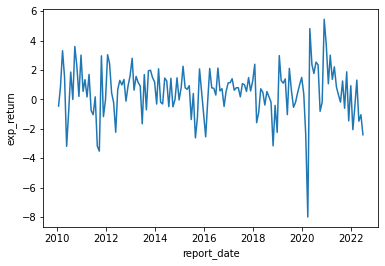

In [14]:
sns.lineplot(data=hf_returns, x="report_date", y="exp_return")

## Let's try to do a portfolio optimization for our popular HFRX indices

In [14]:
hfrx_perf = hf_perf[hf_perf["fund"].isin(["HFRX Global Hedge Fund Index", "HFRX Equal Weighted Strategies Index", 
                                   "HFRX Absolute Return Index",
                                   "HFRX Event Driven Index",
                                   "HFRX Equity Hedge Index",
                                   "HFRX Macro/CTA Index", 
                                   "HFRX Relative Value Arbitrage Index",
                                   "HFRX Market Directional Index",
                                   "HFRX EH: Equity Market Neutral Index",
                                   "HFRX EH: Fundamental Growth Index",
                                   "HFRX EH: Fundamental Value Index",
                                   "HFRX Macro: Systematic Diversified CTA Index" ])]

In [15]:
hfrx_perf['report_month'] = hfrx_perf['report_date'].dt.to_period('M')

hfrx_returns=hfrx_perf[['fund','report_month','performance']]

hfrx_returns=hfrx_returns.pivot_table(index='report_month', columns='fund', values='performance')

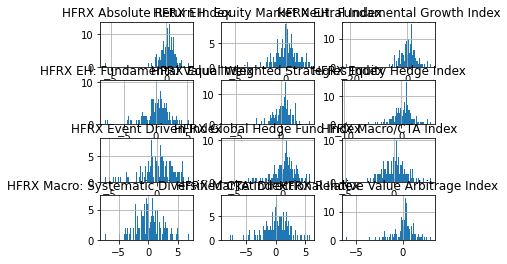

In [16]:
hfrx_returns.hist(bins = 100)

figsize =(15, 7)
# Show plot
plt.show()

In [17]:
index_perf = hf_perf[hf_perf["fund"].isin(["HFRX Event Driven Index",
                                   "HFRX Macro/CTA Index", 
                                   "HFRX Relative Value Arbitrage Index",
                                   "HFRX Market Directional Index",
                                   "HFRX EH: Equity Market Neutral Index",
                                   "HFRX EH: Fundamental Growth Index",
                                   "HFRX EH: Fundamental Value Index"])]

In [18]:
index_perf.nunique()

firm_id              1
firm                 1
fund_id              7
fund                 7
structure            1
inception_date       2
main_strategy        1
sub_strategy         1
report_date        149
performance       1023
nav               1043
dtype: int64

In [19]:
index_perf['report_month'] = index_perf['report_date'].dt.to_period('M')
index_perf.head(2)

,firm_id,firm,fund_id,fund,structure,inception_date,main_strategy,sub_strategy,report_date,performance,nav,report_month
6390,1319,"Hedge Fund Research, Inc.",11516,HFRX Market Directional Index,Index,1998-01-01,HFRX,Index,2010-01-31,0.229,1154.589,2010-01
6391,1319,"Hedge Fund Research, Inc.",11516,HFRX Market Directional Index,Index,1998-01-01,HFRX,Index,2010-02-28,-0.041,1154.112,2010-02


### The performance is basically calculated as the historical ROR (rate of return) based on Net Asset Value

### Net asset value is the value of an entity's assets minus the value of its liabilities, often in relation to open-end or mutual funds, since shares of such funds registered with the U.S. Securities and Exchange Commission are redeemed at their net asset value.

---

Note performance = 0.438 in the report data of Feb 2010 means a change of 0.438% from the previous index NAV of 1113.867 to 118.748

In [20]:
index_perf.loc[index_perf['fund_id'] == 10007].head(5)

,firm_id,firm,fund_id,fund,structure,inception_date,main_strategy,sub_strategy,report_date,performance,nav,report_month


In [21]:
index_returns=index_perf[['fund','report_month','performance']]

index_returns=index_returns.pivot_table(index='report_month', columns='fund', values='performance')

index_nav=index_perf[['fund','report_month','nav']]

index_nav=index_nav.pivot_table(index='report_month', columns='fund', values='nav')

In [22]:
display(index_returns.head(5))
display(index_nav.head(5))

fund,HFRX EH: Equity Market Neutral Index,HFRX EH: Fundamental Growth Index,HFRX EH: Fundamental Value Index,HFRX Event Driven Index,HFRX Macro/CTA Index,HFRX Market Directional Index,HFRX Relative Value Arbitrage Index
report_month,,,,,,,
2010-01,-0.489,-2.811,0.250,0.649,-1.843,0.229,1.627
2010-02,1.550,-0.541,-0.323,-0.119,1.414,-0.041,-0.219
2010-03,-0.038,-1.681,1.331,1.749,1.071,2.372,1.222
2010-04,-0.377,1.396,1.186,0.819,-0.704,1.099,1.341
2010-05,2.080,-3.187,-3.080,-3.225,-0.923,-2.465,-2.912


fund,HFRX EH: Equity Market Neutral Index,HFRX EH: Fundamental Growth Index,HFRX EH: Fundamental Value Index,HFRX Event Driven Index,HFRX Macro/CTA Index,HFRX Market Directional Index,HFRX Relative Value Arbitrage Index
report_month,,,,,,,
2010-01,980.091,1531.607,1101.935,1356.730,1224.445,1154.589,1109.587
2010-02,995.278,1523.322,1098.376,1355.109,1241.754,1154.112,1107.160
2010-03,994.902,1497.707,1112.996,1378.805,1255.059,1181.489,1120.685
2010-04,991.155,1518.614,1126.192,1390.095,1246.220,1194.472,1135.718
2010-05,1011.770,1470.210,1091.501,1345.262,1234.720,1165.030,1102.647


## Calculating Log Returns

In [23]:
log_index_returns = np.log((index_nav/index_nav.shift(1)))
log_index_returns.head(5)

fund,HFRX EH: Equity Market Neutral Index,HFRX EH: Fundamental Growth Index,HFRX EH: Fundamental Value Index,HFRX Event Driven Index,HFRX Macro/CTA Index,HFRX Market Directional Index,HFRX Relative Value Arbitrage Index
report_month,,,,,,,
2010-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02,0.015,-0.005,-0.003,-0.001,0.014,-0.000,-0.002
2010-03,-0.000,-0.017,0.013,0.017,0.011,0.023,0.012
2010-04,-0.004,0.014,0.012,0.008,-0.007,0.011,0.013
2010-05,0.021,-0.032,-0.031,-0.033,-0.009,-0.025,-0.030


In [24]:
log_returns_means= log_index_returns.mean()*12
log_returns_means

fund
HFRX EH: Equity Market Neutral Index   -0.004
HFRX EH: Fundamental Growth Index       0.016
HFRX EH: Fundamental Value Index        0.026
HFRX Event Driven Index                 0.018
HFRX Macro/CTA Index                    0.001
HFRX Market Directional Index           0.009
HFRX Relative Value Arbitrage Index     0.011
dtype: float64

In [25]:
## cov matrix

cov_mat = log_index_returns.cov()*12
cov_mat.head(2)

fund,HFRX EH: Equity Market Neutral Index,HFRX EH: Fundamental Growth Index,HFRX EH: Fundamental Value Index,HFRX Event Driven Index,HFRX Macro/CTA Index,HFRX Market Directional Index,HFRX Relative Value Arbitrage Index
fund,,,,,,,
HFRX EH: Equity Market Neutral Index,0.002,0.002,0.001,0.001,0.000,0.001,0.000
HFRX EH: Fundamental Growth Index,0.002,0.013,0.005,0.004,0.001,0.007,0.003


In [26]:
corr_mat = log_index_returns.corr()
corr_mat

fund,HFRX EH: Equity Market Neutral Index,HFRX EH: Fundamental Growth Index,HFRX EH: Fundamental Value Index,HFRX Event Driven Index,HFRX Macro/CTA Index,HFRX Market Directional Index,HFRX Relative Value Arbitrage Index
fund,,,,,,,
HFRX EH: Equity Market Neutral Index,1.000,0.409,0.310,0.241,0.033,0.262,0.278
HFRX EH: Fundamental Growth Index,0.409,1.000,0.603,0.651,0.250,0.772,0.730
HFRX EH: Fundamental Value Index,0.310,0.603,1.000,0.657,0.237,0.769,0.669
HFRX Event Driven Index,0.241,0.651,0.657,1.000,0.190,0.776,0.748
HFRX Macro/CTA Index,0.033,0.250,0.237,0.190,1.000,0.337,0.148
HFRX Market Directional Index,0.262,0.772,0.769,0.776,0.337,1.000,0.755
HFRX Relative Value Arbitrage Index,0.278,0.730,0.669,0.748,0.148,0.755,1.000


### Random Weights via Monte Carlo Method

In [27]:
number_ports = 25000
number_indices = len(index_nav.columns)
Rf = .015
weight_log=[]
port_info = np.zeros((3,25000))
for x in range(number_ports):   
    weights = np.random.random(number_indices)
    weights /= np.sum(weights)
    #Save Weights
    weight_log.append(weights)
    #Expected Returns
    pret = np.sum(weights*log_index_returns.mean())*12
    #Save Expected Returns
    port_info[1,x] = pret
    #Expected Volatility
    pvol = np.sqrt(np.dot(weights.T,np.dot(log_index_returns.cov()*12, weights)))
    #Save Expected Volatility
    port_info[0,x] = pvol
    #Save Sharpe Ratio
    port_info[2,x] =(pret - Rf)/pvol
    
port_info,weight_log 

(array([[ 0.04212952,  0.04083464,  0.04269579, ...,  0.0425226 ,
          0.04891893,  0.05091124],
        [ 0.01057958,  0.00927223,  0.01065972, ...,  0.00790611,
          0.00902615,  0.01150676],
        [-0.10492453, -0.14026748, -0.10165599, ..., -0.16682645,
         -0.12211729, -0.06861422]]),
 [array([0.04422072, 0.09725309, 0.1860652 , 0.03178451, 0.32094829,
         0.05200685, 0.26772135]),
  array([0.12372327, 0.00384737, 0.01348028, 0.34086149, 0.22902304,
         0.14580572, 0.14325883]),
  array([0.16575028, 0.02380684, 0.19737011, 0.17848727, 0.19507176,
         0.13785861, 0.10165514]),
  array([0.05586953, 0.14369191, 0.13658739, 0.11335913, 0.06229547,
         0.22427   , 0.26392657]),
  array([0.17658829, 0.15342409, 0.06524586, 0.1705855 , 0.1755389 ,
         0.08784214, 0.17077522]),
  array([0.12027343, 0.17071105, 0.00469557, 0.05236488, 0.22397307,
         0.05808281, 0.36989919]),
  array([0.2392403 , 0.02386399, 0.15336512, 0.0495156 , 0.11365067,

In [28]:
max_sharpe_idx = np.argmax(port_info[2])#Provides index location of Max Sharpe Ratio
sdp, rp = port_info[0,max_sharpe_idx], port_info[1,max_sharpe_idx]
max_sharpe_allocation = pd.DataFrame(weight_log[max_sharpe_idx],index=index_returns.columns,columns=['Max_Sharpe_Allocation'])
max_sharpe_allocation.Max_Sharpe_Allocation = [round(i*100,2)for i in max_sharpe_allocation.Max_Sharpe_Allocation]
max_sharpe_allocation = max_sharpe_allocation.T

min_vol_idx = np.argmin(port_info[0])
sdp_min, rp_min = port_info[0,min_vol_idx], port_info[1,min_vol_idx]
min_vol_allocation = pd.DataFrame(weight_log[min_vol_idx],index=index_returns.columns,columns=['Min_Vol_Allocation'])
min_vol_allocation.Min_Vol_Allocation = [round(i*100,2)for i in min_vol_allocation.Min_Vol_Allocation]
min_vol_allocation = min_vol_allocation.T

max_sharpe_allocation,min_vol_allocation

(fund                   HFRX EH: Equity Market Neutral Index  \
 Max_Sharpe_Allocation                                 1.170   
 
 fund                   HFRX EH: Fundamental Growth Index  \
 Max_Sharpe_Allocation                             11.440   
 
 fund                   HFRX EH: Fundamental Value Index  \
 Max_Sharpe_Allocation                            34.930   
 
 fund                   HFRX Event Driven Index  HFRX Macro/CTA Index  \
 Max_Sharpe_Allocation                   46.050                 1.350   
 
 fund                   HFRX Market Directional Index  \
 Max_Sharpe_Allocation                          2.420   
 
 fund                   HFRX Relative Value Arbitrage Index  
 Max_Sharpe_Allocation                                2.630  ,
 fund                HFRX EH: Equity Market Neutral Index  \
 Min_Vol_Allocation                                37.480   
 
 fund                HFRX EH: Fundamental Growth Index  \
 Min_Vol_Allocation                              0.44

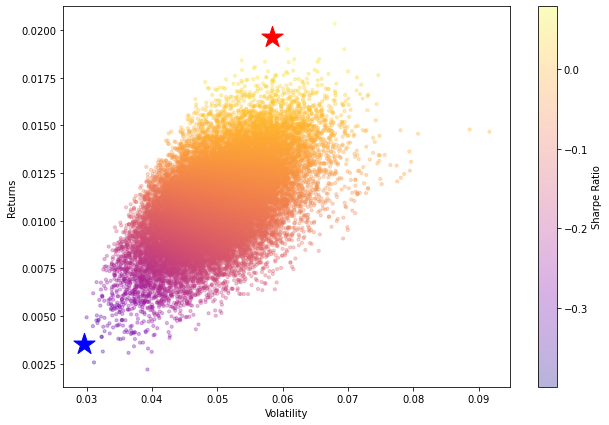

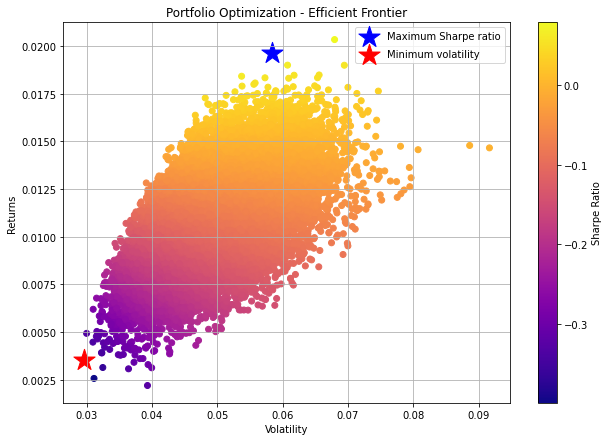

In [29]:
plt.figure(figsize=(10,7))
plt.scatter(port_info[0,:],port_info[1,:],c=port_info[2,:],cmap='plasma', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
plt.scatter(sdp_min,rp_min,marker='*',color='b',s=500, label='Minimum volatility')
plt.show()

#
plt.figure(figsize=(10, 7))
#Assign data to axis, Vol,Returns, C= Sharpe Ratio, Cmap = 'Style'
plt.scatter(port_info[0,:],port_info[1,:],c=port_info[2,:],cmap='plasma')
#Label Colorbar
plt.colorbar(label='Sharpe Ratio')
#Label Maximum Sharpe and Minimum Vol
plt.scatter(sdp,rp,marker='*',color='b',s=500, label='Maximum Sharpe ratio')
plt.scatter(sdp_min,rp_min,marker='*',color='r',s=500, label='Minimum volatility')
#Provide a title
plt.title('Portfolio Optimization - Efficient Frontier')
plt.grid(True)
#Label X and Y Access
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.legend(labelspacing=0.8)
plt.show()

## Optimization - Maximum Sharpe Ratio

In [30]:
def optim_info(weights, returns, cov_mat):
    pvol = np.sqrt(np.dot(weights.T,np.dot(cov_mat, weights)))
    pret = np.sum(weights*log_index_returns.mean())*252
    return np.array([pret,pvol,(pret-Rf)/pvol])
    
def neg_sharpe_ratio(weights, returns):
    return -optim_info(weights,returns, cov_mat)[2]


args = (log_index_returns.mean(), cov_mat, Rf)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bound = (0.0,1.0)
bounds = tuple(bound for x in range(number_indices))
optimized = sco.minimize(neg_sharpe_ratio, weights, args=log_index_returns.mean(),
                        method='SLSQP', bounds=bounds, constraints=constraints)
optimized

     fun: -7.9174498104055715
     jac: array([ 2.96266681,  4.26949859, -0.24767673, -0.24811763,  0.96329147,
        5.65595502,  0.0527364 ])
 message: 'Optimization terminated successfully'
    nfev: 40
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([3.18636843e-16, 1.27382193e-14, 7.06217749e-01, 2.93782251e-01,
       0.00000000e+00, 2.49301661e-14, 0.00000000e+00])

In [31]:
Max_Sharpe_Opt_Weights = pd.DataFrame(optimized['x'].round(3),index_returns.columns, columns=['Max_Sharpe_Opt_Weights'])
print(Max_Sharpe_Opt_Weights.T)
print("Expected return, volatility and Sharpe ratio:",optim_info(optimized['x'], index_returns, cov_mat))

fund                    HFRX EH: Equity Market Neutral Index  \
Max_Sharpe_Opt_Weights                                 0.000   

fund                    HFRX EH: Fundamental Growth Index  \
Max_Sharpe_Opt_Weights                              0.000   

fund                    HFRX EH: Fundamental Value Index  \
Max_Sharpe_Opt_Weights                             0.706   

fund                    HFRX Event Driven Index  HFRX Macro/CTA Index  \
Max_Sharpe_Opt_Weights                    0.294                 0.000   

fund                    HFRX Market Directional Index  \
Max_Sharpe_Opt_Weights                          0.000   

fund                    HFRX Relative Value Arbitrage Index  
Max_Sharpe_Opt_Weights                                0.000  
Expected return, volatility and Sharpe ratio: [0.49425218 0.06053113 7.91744981]


## Optimization - Minimum Volatility

In [32]:
def portfolio_volatility(weights, mean_returns, cov_mat):
    return optim_info(weights, mean_returns, cov_mat)[1]


args = (log_index_returns.mean(), cov_mat)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bound = (0.0,1.0)
bounds = tuple(bound for asset in range(number_indices))
optimized1 = sco.minimize(portfolio_volatility, number_indices*[1./number_indices,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
optimized1

     fun: 0.027076881459922167
     jac: array([0.02762217, 0.07628402, 0.040012  , 0.03204626, 0.02667024,
       0.05258122, 0.02676877])
 message: 'Optimization terminated successfully'
    nfev: 88
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.39721703, 0.        , 0.        , 0.        , 0.31336091,
       0.        , 0.28942206])

In [33]:
Min_Vol_Opt_Weights = pd.DataFrame(optimized1['x'].round(3),index_returns.columns, columns=['Min_Vol_Opt_Weights'])
print(Min_Vol_Opt_Weights.T)

print("Expected return, volatility and Sharpe ratio:",optim_info(optimized1['x'],index_returns, cov_mat))

fund                 HFRX EH: Equity Market Neutral Index  \
Min_Vol_Opt_Weights                                 0.397   

fund                 HFRX EH: Fundamental Growth Index  \
Min_Vol_Opt_Weights                              0.000   

fund                 HFRX EH: Fundamental Value Index  \
Min_Vol_Opt_Weights                             0.000   

fund                 HFRX Event Driven Index  HFRX Macro/CTA Index  \
Min_Vol_Opt_Weights                    0.000                 0.313   

fund                 HFRX Market Directional Index  \
Min_Vol_Opt_Weights                          0.000   

fund                 HFRX Relative Value Arbitrage Index  
Min_Vol_Opt_Weights                                0.289  
Expected return, volatility and Sharpe ratio: [0.04299018 0.02707688 1.03372992]


## Optimize Portfolios for a Target Return

In [34]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return optim_info(weights, mean_returns, cov_mat)[0]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    eff_port_return = sco.minimize(portfolio_volatility, weights, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return eff_port_return


Target_Portfolio = efficient_return(log_index_returns.mean(),cov_mat, .10) 
Efficient_Portfolio_Weights = pd.DataFrame(Target_Portfolio['x'].round(3),index_returns.columns, columns=['Efficient_Portfolio_Weights'])
print(Efficient_Portfolio_Weights.T)
print("Expected return, volatility and Sharpe ratio:",optim_info(Target_Portfolio['x'],index_returns, cov_mat))

fund                         HFRX EH: Equity Market Neutral Index  \
Efficient_Portfolio_Weights                                 0.243   

fund                         HFRX EH: Fundamental Growth Index  \
Efficient_Portfolio_Weights                              0.000   

fund                         HFRX EH: Fundamental Value Index  \
Efficient_Portfolio_Weights                             0.004   

fund                         HFRX Event Driven Index  HFRX Macro/CTA Index  \
Efficient_Portfolio_Weights                    0.014                 0.289   

fund                         HFRX Market Directional Index  \
Efficient_Portfolio_Weights                          0.000   

fund                         HFRX Relative Value Arbitrage Index  
Efficient_Portfolio_Weights                                0.450  
Expected return, volatility and Sharpe ratio: [0.1        0.02822148 3.01189023]


## Optimized Portfolios within a Range

In [35]:
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

returnsRange = np.linspace(0.0,0.5,50) 
eff_RangePorts=efficient_frontier(log_index_returns.mean(),cov_mat,returnsRange)

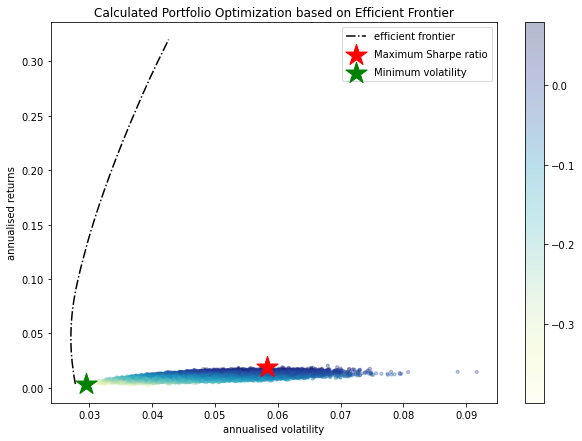

In [36]:
plt.figure(figsize=(10, 7))
plt.scatter(port_info[0,:],port_info[1,:],c=port_info[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
plt.colorbar()
plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

target = np.linspace(rp_min, 0.32, 250)
efficient_portfolios = efficient_frontier(log_returns_means, cov_mat, target)
plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
plt.xlabel('annualised volatility')
plt.ylabel('annualised returns')
plt.legend(labelspacing=0.8)

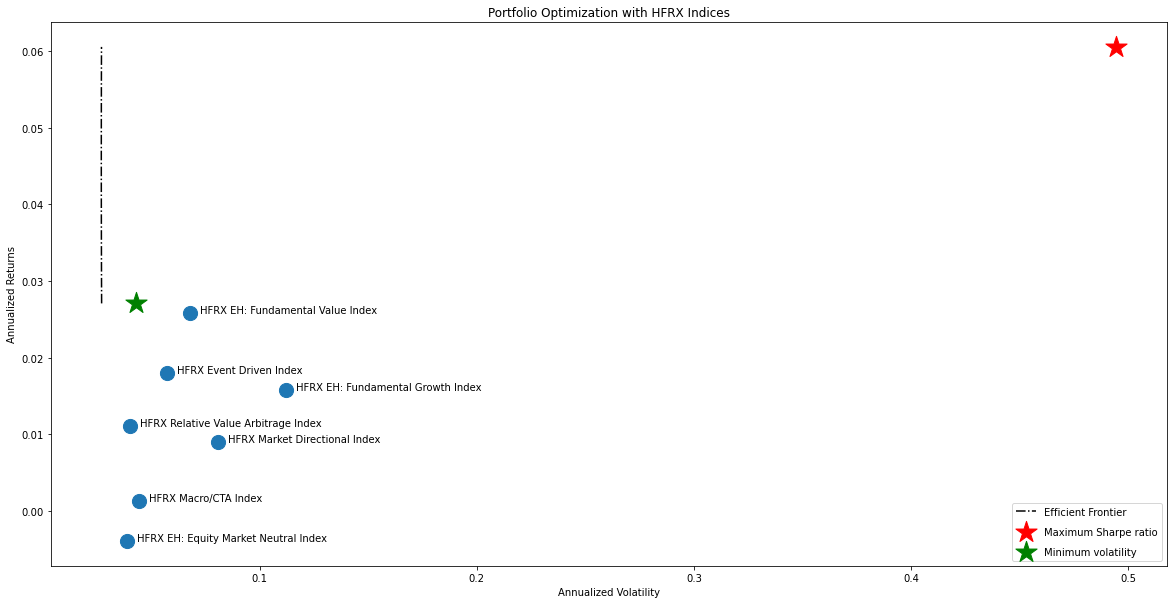

In [37]:
sdp, rp, cmp = optim_info(optimized['x'], index_returns, cov_mat)
sdp_min, rp_min, cmpmin = optim_info(optimized1['x'],index_returns, cov_mat)

an_vol = np.std(log_index_returns) * np.sqrt(12)
an_rt = log_index_returns.mean() * 12
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(an_vol,an_rt,marker='o',s=200)
for i, txt in enumerate(index_returns.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
target = np.linspace(rp_min, rp, 50)
efficient_portfolios = efficient_frontier(log_index_returns.mean(), cov_mat, target)
ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='Efficient Frontier')
ax.set_title('Portfolio Optimization with HFRX Indices')
ax.set_xlabel('Annualized Volatility')
ax.set_ylabel('Annualized Returns')
ax.legend(labelspacing=1)

---

## Risk-return ratios and portfolio metrics

### We can calculate the Beta by creating a benchmark for Hedge Fund Returns

Let us consisder HFRX Global Hedge Fund Index as the benchmark for Hedge Fund Returns

In [38]:
benchmark_perf = hf_perf[hf_perf["fund"].isin(["HFRX Global Hedge Fund Index"])]
benchmark_perf['report_month'] = benchmark_perf['report_date'].dt.to_period('M')

benchmark_returns=benchmark_perf[['fund','report_month','performance']]
benchmark_returns=benchmark_returns.pivot_table(index='report_month', columns='fund', values='performance')

benchmark_nav=benchmark_perf[['fund','report_month','nav']]
benchmark_nav=benchmark_nav.pivot_table(index='report_month', columns='fund', values='nav')

log_benchmark_returns = np.log((benchmark_nav/benchmark_nav.shift(1)))

In [39]:
# display(benchmark_perf.head(5))
# display(benchmark_returns.head(5))
# display(benchmark_nav.head(5))
# display(log_benchmark_returns.head(5))

In [40]:
hfport_perf = index_perf

hfport_perf['report_month'] = hfport_perf['report_date'].dt.to_period('M')

hfport_returns=hfport_perf[['fund','report_month','performance']]
hfport_returns=hfport_returns.pivot_table(index='report_month', columns='fund', values='performance')

hfport_nav=hfport_perf[['fund','report_month','nav']]
hfport_nav=hfport_nav.pivot_table(index='report_month', columns='fund', values='nav')

log_hfport_returns = np.log((hfport_nav/hfport_nav.shift(1)))

In [41]:
# display(hfport_perf.head(5))
# display(hfport_returns.head(5))
# display(hfport_nav.head(5))
# display(log_hfport_returns.head(5))

### Random Weights via Monte Carlo Method

In [42]:
#set seed for reproduceable results
np.random.seed(600)
number_port = 25000
number_indices = len(hfport_nav.columns)

#array to store weights
weights_store = np.zeros((number_indices,len(hfport_nav.columns)))

#array to store returns
returns_store = np.zeros(number_indices)

#array to store returns
vol_store = np.zeros(number_indices)

#array to store Sharpe Ratio info
sharpe_store=np.zeros(number_indices)

#set Riskfree Rate, necessary for sharpe ratio
Rf = .015

for x in range(number_indices):
    #Weights
    weights = np.array(np.random.random(number_indices))
    weights /= np.sum(weights)
    #Save Weights
    weights_store[x,:] = weights
    
    #Save Expected Returns
    returns_store[x] = np.sum(weights*log_hfport_returns.mean())*12
   
    #Save Expected Volatility
    vol_store[x] = np.sqrt(np.dot(weights.T,np.dot(log_hfport_returns.cov()*12, weights)))
   
    #Save Sharpe Ratio
    sharpe_store[x] = (returns_store[x] - Rf)/vol_store[x]
    
print('Max Sharpe Ratio:',sharpe_store.max(),'Min Vol:',vol_store.min())

Max Sharpe Ratio: 0.04357477431984002 Min Vol: 0.03588922011646039


In [43]:
#Find location and allocation of Max Sharpe portfolio
max_sharpe_idx = np.argmax(sharpe_store)
max_sharpe_return = returns_store[max_sharpe_idx]
max_sharpe_vol = vol_store[max_sharpe_idx]
max_sharpe_wght = weights_store[max_sharpe_idx]

max_sharpe_allocation = pd.DataFrame(weights_store[max_sharpe_idx],index=hfport_returns.columns,columns=['Max_Sharpe_Allocation'])
max_sharpe_allocation.Max_Sharpe_Allocation = [round(i*100,2)for i in max_sharpe_allocation.Max_Sharpe_Allocation]
max_sharpe_allocation = max_sharpe_allocation.T

max_sharpe_allocation

fund,HFRX EH: Equity Market Neutral Index,HFRX EH: Fundamental Growth Index,HFRX EH: Fundamental Value Index,HFRX Event Driven Index,HFRX Macro/CTA Index,HFRX Market Directional Index,HFRX Relative Value Arbitrage Index
Max_Sharpe_Allocation,2.550,9.390,28.780,30.840,1.600,3.230,23.610


In [44]:
print('Max Sharpe Portfolio Returns = ',max_sharpe_return)
print('Max Sharpe Portfolio Vol = ',max_sharpe_vol)

Max Sharpe Portfolio Returns =  0.01730277090267949
Max Sharpe Portfolio Vol =  0.0528464217801127


In [45]:
#Find location and allocation of Min Vol portfolio
min_vol_idx = np.argmin(vol_store)
min_vol_return = returns_store[min_vol_idx]
min_vol_vol = vol_store[min_vol_idx]
min_vol_allocation = pd.DataFrame(weights_store[min_vol_idx],index=hfport_returns.columns,columns=['Min_Vol_Allocation'])
min_vol_allocation.Min_Vol_Allocation = [round(i*100,2)for i in min_vol_allocation.Min_Vol_Allocation]
min_vol_allocation = min_vol_allocation.T

min_vol_allocation

fund,HFRX EH: Equity Market Neutral Index,HFRX EH: Fundamental Growth Index,HFRX EH: Fundamental Value Index,HFRX Event Driven Index,HFRX Macro/CTA Index,HFRX Market Directional Index,HFRX Relative Value Arbitrage Index
Min_Vol_Allocation,4.490,0.480,4.470,10.390,34.070,8.640,37.460


In [46]:
print('Min Vol Portfolio Returns = ',min_vol_return)
print('Min Vol Portfolio Vol = ',min_vol_vol)

Min Vol Portfolio Returns =  0.008292745721800665
Min Vol Portfolio Vol =  0.03588922011646039


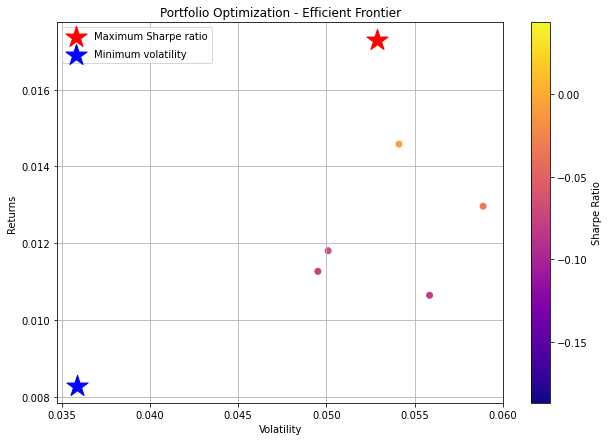

In [47]:
plt.figure(figsize=(10, 7))
#Assign data to axis, Vol,Returns, C= Sharpe Ratio, Cmap = 'Style'
plt.scatter(vol_store,returns_store,c=sharpe_store,cmap='plasma')
#Label Colorbar
plt.colorbar(label='Sharpe Ratio')
#Label Maximum Sharpe and Minimum Vol
plt.scatter(max_sharpe_vol,max_sharpe_return,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
plt.scatter(min_vol_vol,min_vol_return,marker='*',color='b',s=500, label='Minimum volatility')
#Provide a title
plt.title('Portfolio Optimization - Efficient Frontier')
plt.grid(True)
#Label X and Y Access
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.legend(labelspacing=0.8)
plt.show()

In [48]:
log_benchmark_returns.head(5)

fund,HFRX Global Hedge Fund Index
report_month,
2010-01,NaN
2010-02,0.003
2010-03,0.014
2010-04,0.008
2010-05,-0.027


In [49]:
#Calculate Betas for each individual asset 

#Create a list to hold Betas
outputs=[]

for column in log_hfport_returns:
    #concatentate market and log_returns[column] in to one dataframe
    df = pd.DataFrame({'Benchmark':log_benchmark_returns['HFRX Global Hedge Fund Index'].dropna(),'Return':log_hfport_returns[column].dropna()})
    
    #Conduct Linear Regression to find Beta
    rgress = sm.OLS(df.Return,sm.tools.add_constant(df.Benchmark)).fit()
    
    #Collect individual Regressions 
    outputs.append(rgress.params[1]) 

#Calculate Weighted Average of Betas    
port_beta= np.sum(np.dot(outputs,(max_sharpe_allocation.T)/100))
print(port_beta)

1.167704902247997


### Treynor Ratio

In [50]:
#Assign Riskfree Rate or Threshold
rf = .015

ms_Treynor = (max_sharpe_return - rf)/port_beta

mv_Treynor = (min_vol_return - rf)/port_beta

print('Max Sharpe Treynor = ', ms_Treynor)
print('Min Vol Treynor = ', mv_Treynor)

Max Sharpe Treynor =  0.0019720486727822497
Min Vol Treynor =  -0.005743963449401404


### Information Ratio

In [51]:
#Find excess returns less the Market Benchmark
ms_ret_less_bench = max_sharpe_return - log_benchmark_returns.mean()
ms_info_ratio = ms_ret_less_bench/max_sharpe_vol

mv_ret_less_bench = min_vol_return - log_benchmark_returns.mean()
mv_info_ratio = mv_ret_less_bench/min_vol_vol

print('Max Sharpe Info Ratio = ',ms_info_ratio.values)
print('Min Vol Info Ratio = ', mv_info_ratio.values)

Max Sharpe Info Ratio =  [0.30455649]
Min Vol Info Ratio =  [0.19740455]


### Omega Ratio

In [52]:
#Lower Partial Moment
_LPM=[]
for column in log_hfport_returns:
        y=log_hfport_returns[column][log_hfport_returns[column]-rf<0]
        m=len(y)
        total=0.0
        for i in sp.arange(m):
            total+=(y[i]-rf)**2
        _LPM.append(total/(m-1))
    

lpmf = pd.DataFrame(_LPM,index=hfport_returns.columns,columns=['LPM'])
print(lpmf)
Weighted_Avg_LPM= np.sum(np.dot(_LPM,(max_sharpe_allocation.T)/100))
print("Weighted Average LPM=",Weighted_Avg_LPM)

                                       LPM
fund                                      
HFRX EH: Equity Market Neutral Index 0.000
HFRX EH: Fundamental Growth Index    0.002
HFRX EH: Fundamental Value Index     0.001
HFRX Event Driven Index              0.001
HFRX Macro/CTA Index                 0.000
HFRX Market Directional Index        0.001
HFRX Relative Value Arbitrage Index  0.000
Weighted Average LPM= 0.0006416768388176


In [53]:
#First Order Lower Partial Moment
#A larger ratio indicates that the asset provides more gains relative to losses for some threshold r 
#and so would be preferred by an investor

ms_omega_ratio = (max_sharpe_return - rf) / Weighted_Avg_LPM
mv_omega_ratio = (min_vol_return -rf)/ Weighted_Avg_LPM

print('Min Vol Omega Ratio = ',mv_omega_ratio)
print('Max Sharpe Omega Ratio =',ms_omega_ratio)

Min Vol Omega Ratio =  -10.452698106664727
Max Sharpe Omega Ratio = 3.5886769840761916


### Sortino Ratio

In [54]:
#Second Order Lower Partial moment
TDD = np.sqrt(Weighted_Avg_LPM) 
ms_sortino_ratio = (max_sharpe_return - rf) /TDD
ms_sortino_ratio

mv_sortino_ratio = (min_vol_return - rf) /TDD
mv_sortino_ratio
print('Portfolio Standard Deviation = ',max_sharpe_vol)
print('Target Downside Deviation = ',TDD)
print('Max Sharpe Sortino Ratio = ',ms_sortino_ratio)
print('Min Volatility Sortino Ratio = ',mv_sortino_ratio)

#Third Partial Moment
ms_kappa_ratio = (max_sharpe_return - rf) / np.power(Weighted_Avg_LPM,float(1/3))
mv_kappa_ratio = (min_vol_return - rf) / np.power(Weighted_Avg_LPM,float(1/3))

print('Max_Sharpe_Kappa_Ratio = ',ms_kappa_ratio)
print('Min_Vol_Kappa_Ratio = ',mv_kappa_ratio)

Portfolio Standard Deviation =  0.0528464217801127
Target Downside Deviation =  0.02533134103867381
Max Sharpe Sortino Ratio =  0.0909060005612734
Min Volatility Sortino Ratio =  -0.2647808605142242
Max_Sharpe_Kappa_Ratio =  0.02669799281799504
Min_Vol_Kappa_Ratio =  -0.07776293609558267
